## Use Predicto Trade Picks with Alpaca to place hedged orders
Sample usage to retrieve latest trade picks and submit to alpaca programmatically 
(https://predic.to) (https://alpaca.markets)

This is a simple example on how to retrieve latest trade pick for a ticker and then place an alpaca order with target price and stoploss price.

### For Predicto authentication
To use predicto api and reproduce this notebook, you'll need to have a valid Predicto account. 
If you don't have one, you can create one here: https://predic.to and get a free trial period.

To authenticate you'll need an api key. To retrieve it, login to https://predic.to and head to your [settings page](https://predic.to/account). Then paste it in the `predicto_api_key` variable below.

If you get any exception/error while running below code, please make sure your api key is correct and your subscription/trial is not expired.
Please note that there is a limit to the number of requests you can make per minute, depending on your account type.

### For Alpaca authentication
You'll need an alpaca.markets account. Then you can retrieve your API Key ID and Endpoint from your account page. You can use either paper money or real money. We recommend to experiment with a paper money account first.

More info about Alpaca trade api can be found here: https://github.com/alpacahq/alpaca-trade-api-python/

### Import needed packages

In [1]:
import sys
sys.path.append("../predicto_api/")

import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import IPython.display as display

import alpaca_trade_api as tradeapi

from predicto_api_wrapper import PredictoApiWrapper, TradeAction, TradeOrderType
from alpaca_api_wrapper import AlpacaApiWrapper

### Prepare and initialize our Predicto wrapper
You'll need to have a valid Predicto account as mentioned above, and get an api key. Then replace the `predicto_api_key` variable below

In [2]:
predicto_api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
predicto_api_wrapper = PredictoApiWrapper(predicto_api_key)

### Prepare and initialize our Alpaca API wrapper
You'll need to have a valid Alpaca account as mentioned above, and replace below variables with your own credentials.

In [3]:
alpaca_api_endpoint = 'https://paper-api.alpaca.markets' # use paper money endpoint for now (test env)
alpaca_api_key_id = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
alpaca_api_secret_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

alpaca_wrapper = AlpacaApiWrapper(alpaca_api_endpoint, alpaca_api_key_id, alpaca_api_secret_key)

### Make sure our alpaca keys work as expected
Retrieve some latest prices

In [21]:
print('Latest price of AAPL is: ', alpaca_wrapper.get_latest_price('AAPL'))
print('Latest price of FB   is: ', alpaca_wrapper.get_latest_price('FB'))
print('Latest price of MSFT is: ', alpaca_wrapper.get_latest_price('MSFT'))
print('Latest price of NIO  is: ', alpaca_wrapper.get_latest_price('NIO'))
print('Latest price of TSLA is: ', alpaca_wrapper.get_latest_price('TSLA'))
print('Latest price of V    is: ', alpaca_wrapper.get_latest_price('V'))

print('Looks good \N{grinning face}')

Latest price of AAPL is:  122.77
Latest price of FB   is:  288.25
Latest price of MSFT is:  216.87
Latest price of NIO  is:  46.96
Latest price of TSLA is:  582.95
Latest price of V    is:  212.195
Looks good 😀


### Let's start by retrieving all supported tickers for Forecasting in Predicto
We generate forecasts and trade picks for a limited amount of stocks for the time being

In [5]:
# Get all supported stocks
stocks_json = predicto_api_wrapper.get_supported_tickers()
stocks_df = pd.DataFrame(stocks_json)

# print some information
print('Total tickers supported: {0}'.format(len(stocks_df)))
print('Here is a sample:')
stocks_df.head(15)

Total tickers supported: 47
Here is a sample:


,RelatedStock,RelatedCompany
0,AMD,AMD
1,ATVI,Activision
2,BABA,Alibaba
3,AMZN,Amazon
4,AAL,American Airlines
5,AAPL,Apple
6,BIDU,Baidu
7,BAC,Bank of America
8,BKNG,Booking Holdings
9,CVX,Chevron


### Let's inspect forecasts and trade picks that were generated yesterday (All forecasts are for 15 days ahead)

In [6]:
sdate = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
print(sdate)

2020-11-30


### Let's see what forecast we got for Visa Inc (V)
We predict an up trend forecast, and recommended action is BUY with entry/target/stopLoss prices

Forecast for V on 2020-11-30


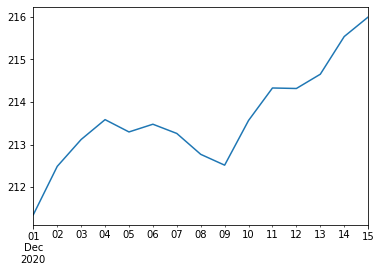

            Prediction  Uncertainty
2020-12-01  211.357222     0.005530
2020-12-02  212.491787     0.008681
2020-12-03  213.122432     0.012845
2020-12-04  213.588321     0.017380
2020-12-05  213.299516     0.020842
2020-12-06  213.480570     0.023784
2020-12-07  213.263975     0.028644
2020-12-08  212.774085     0.033938
2020-12-09  212.519855     0.037617
2020-12-10  213.569116     0.042350
2020-12-11  214.330944     0.046177
2020-12-12  214.319051     0.050063
2020-12-13  214.653720     0.053888
2020-12-14  215.537879     0.056529
2020-12-15  215.995569     0.061086

Trade Pick generated based on forecast for V on 2020-11-30
---------------------------------------
Action          : 	Buy
Entry price     : 	210.35
Target price    : 	213.7373411153
StopLoss price  : 	209.5031647212
Expiration Date : 	Monday, Dec 14
Predicted change: 	1.61 %
---------------------------------------




In [14]:
(forecast_json, trade_pick_json) = predicto_api_wrapper.get_forecast_and_tradepick_info('V', sdate, True)

### That seems interesting, let's submit a hedged order to alpaca using above information

### First, show all my holding positions in Alpaca paper account
It's all fake money btw, it's a paper testing account :)

In [15]:
positions = alpaca_wrapper.get_holding_positions()

Holding 116 shares of WORK
Holding 128 shares of LYFT
Holding -41 shares of JPM
Holding -102 shares of INTC
Holding -111 shares of GM
Holding -249 shares of DBX
Holding -122 shares of DAL
Holding -18 shares of BABA
Holding 1 shares of AMZN
Holding -336 shares of AAL


### Inspect our V trade pick json

In [16]:
trade_pick_json

{'Id': 89899,
 'Symbol': 'V',
 'ModelType': 200,
 'StrategyId': 1,
 'StartingPrice': 210.35,
 'TargetSellPrice': 213.7373411153,
 'TargetStopLossPrice': 209.5031647212,
 'HorizonDays': 14,
 'TradeAction': 1,
 'SDate': '2020-11-30',
 'ForecastSlope': 0.0010841045,
 'BenchmarkROI': None,
 'ActualROI': None,
 'ActualSellPrice': None,
 'ActualSellDate': None,
 'HoldingDays': None,
 'AvgUncertainty': 0.0333254621,
 'Last2WeeksStdPctChange': 0.0118145172,
 'Last2WeeksPricePctChange': -0.011048425,
 'RelatedStock': 'V',
 'RelatedCompany': 'Visa',
 'DayOfWeek': 0,
 'ExpirationDate': 'Monday, Dec 14',
 'TradeTotalDays': None,
 'TargetPricePctChange': 0.0161033569,
 'TargetPricePctChangeAbs': 0.0161033569,
 'ModelTypeStr': 'models_avg_tradeable',
 'SDateReadable': 'Monday, Nov 30',
 'AverageROI': 0.0064545607,
 'ActualROIZeroForOngoing': 0.0}

### Prepare our alpaca order parameters
Symbol, TradeAction, Investment amount, Entry price, exit price, stop loss price etc

In [22]:
# Generic parameters like symbol, trade action etc
symbol = trade_pick_json['Symbol']
trade_action = trade_pick_json['TradeAction']
generated_date = trade_pick_json['SDate']

# Entry price, exit price, stop loss price
entry_price = trade_pick_json['StartingPrice']
target_price = trade_pick_json['TargetSellPrice']
stop_loss_price = trade_pick_json['TargetStopLossPrice']

# How many stocks to BUY or SELL? You need to provide a max Investment amount available, and quantity
# - if quantity is None or 0, entire investment amount will be used
# For now let's assume we will use $1000 for our next trade
investmentAmount = 1000
quantity = None

### Step 1 of 2: Submit our market order to Alpaca
### Be Carefull: if action is SELL this mean that we are going to short the stock! Make sure you understand the risks of shorting before using those trade orders. Otherwise you can choose to only use BUY orders.
If you see any error, check the error msg. 

For example, our alpaca api wrapper only allows you to submit orders when the market is open! 

This is to make sure that market order can be filled so that we can go ahead and set target price and stop loss orders for it.

In [18]:
# Create a client order id, for easy tracking
client_market_order_id = 'Predicto__{0}_{1}_{2}_market'.format(generated_date, symbol, trade_action)

# submit the order to alpaca
market_order_result = alpaca_wrapper.submit_order(
                                            TradeOrderType.Market,
                                            TradeAction(int(trade_action)), 
                                            symbol, 
                                            quantity, 
                                            investmentAmount, 
                                            entry_price, 
                                            target_price, 
                                            stop_loss_price,
                                            client_market_order_id)

# Keep in mind that if price changed since the Predicto Trade Pick generation  (very possible due to pre-market and after-hours activity)
# then target price and stop loss prices will be re-adjusted, and order will only be submitted if it makes sense
# e.g. if action is BUY and entry price is more than expected we'll cancel,
#      if action is BUY and entry price is less than expected we'll go through, etc
# (more details on this logic in AlpacaApiWrapper.validate_latest_price_and_stoploss method)

# unpack market order result
if market_order_result:
    (marker_order, newStartingPrice, newTargetPrice, newStopLossPrice, newQuantity) = market_order_result
    
    print()
    print('Order details')
    print('newStartingPrice : ', newStartingPrice)
    print('newTargetPrice   : ', newTargetPrice)
    print('newStopLossPrice : ', newStopLossPrice)
    print('newQuantity      : ', newQuantity)
    
    print()
    print(market_order_result)

Expected price: 210.35
Actual   price: 212.22
Original stopLossPrice: 209.5031647212
New stopLossPrice     : 211.3656364018686
Success: submit_market_order ID: e2030d55-a355-47f3-94d5-a2fe8b86a9bb

Order details
newStartingPrice :  212.22
newTargetPrice   :  213.7373411153
newStopLossPrice :  211.3656364018686
newQuantity      :  4

(Order({   'asset_class': 'us_equity',
    'asset_id': '4f5baf1e-0e9b-4d85-b88a-d874dc4a3c42',
    'canceled_at': None,
    'client_order_id': 'Predicto__2020-11-30_V_1_market',
    'created_at': '2020-12-01T18:53:32.485883Z',
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'filled_qty': '0',
    'hwm': None,
    'id': 'e2030d55-a355-47f3-94d5-a2fe8b86a9bb',
    'legs': None,
    'limit_price': None,
    'order_class': '',
    'order_type': 'market',
    'qty': '4',
    'replaced_at': None,
    'replaced_by': None,
    'replaces': None,
    'side': 'buy',
    'status': 'acc

### Note that market order entry price and stop loss price have been readjusted before making the order to match latest prices. 
Expected price: 210.35 but Actual price: 212.22




### Step 2 of 2: Hedge our Trade Pick using target price and stop loss order
We can do this using an OCO order (one-cancels-other). For more info check alpaca api [relevant documentation](https://alpaca.markets/docs/trading-on-alpaca/orders/#:~:text=OCO%20Orders,only%20exit%20order%20is%20supported.)

If you see any error, check the error msg. For example, you can only submit oco orders for market orders that have been already filled!

In [19]:
if market_order_result and marker_order:
    # Create a client order id, for easy tracking
    client_oco_order_id = 'Predicto__{0}_{1}_{2}_oco'.format(generated_date, symbol, trade_action)

    # submit the order to alpaca (oco order will go through only if above market order was filled successfully)
    oco_order_result = alpaca_wrapper.open_oco_position(
                                            marker_order.id, 
                                            symbol, 
                                            newTargetPrice, 
                                            newStopLossPrice, 
                                            client_oco_order_id)

    # inspect
    print()
    print(oco_order_result)
else:
    print("Market order not found")

Success: open_oco_position ID: cdf61261-f8b9-4a1f-a4ed-55ae7ebac750

Order({   'asset_class': 'us_equity',
    'asset_id': '4f5baf1e-0e9b-4d85-b88a-d874dc4a3c42',
    'canceled_at': None,
    'client_order_id': 'Predicto__2020-11-30_V_1_oco',
    'created_at': '2020-12-01T18:53:45.346548Z',
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'filled_qty': '0',
    'hwm': None,
    'id': 'cdf61261-f8b9-4a1f-a4ed-55ae7ebac750',
    'legs': [   {   'asset_class': 'us_equity',
                    'asset_id': '4f5baf1e-0e9b-4d85-b88a-d874dc4a3c42',
                    'canceled_at': None,
                    'client_order_id': 'ef2ccc05-76e1-46f9-8e23-150e9d196396',
                    'created_at': '2020-12-01T18:53:45.346548Z',
                    'expired_at': None,
                    'extended_hours': False,
                    'failed_at': None,
                    'filled_at': None,
                    '

### If everything went according to plan and market order was filled, we should see the new V position in holding positions
And there it is - we now have 4 shares of V (matching our maximum investment amount of: 4 shares * \\$212.22 <= \\$1000)

In [20]:
positions = alpaca_wrapper.get_holding_positions()

Holding 116 shares of WORK
Holding 4 shares of V
Holding 128 shares of LYFT
Holding -41 shares of JPM
Holding -102 shares of INTC
Holding -111 shares of GM
Holding -249 shares of DBX
Holding -122 shares of DAL
Holding -18 shares of BABA
Holding 1 shares of AMZN
Holding -336 shares of AAL


## And this was a very simple example on how to use Predicto forecasts and Trade Picks with Alpaca API!
For robust systems, it's very important to handle all errors and always verify occasionally that there are no orphan orders. ideally using some kind of automated supervisor. But this is out of scope for this notebook.

### As a last example and exercise
### Here is how to get latest forecasts with a predicted absolute move >= 3%
You can filter based on several fields of the prediction and decide which trade picks you want to submit

Feel free to experiment with difference fields

In [37]:
# retrieve all supported stocks
stocks_json = predicto_api_wrapper.get_supported_tickers()
stocks_df = pd.DataFrame(stocks_json)

# our predicted move threshold
abs_change_pct_threshold = 0.03

# iterate and check for the ones with >= 3% predicted abs change
sdate = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
for symbol in stocks_df.RelatedStock:
    try:
        (forecast_json, tp_json) = predicto_api_wrapper.get_forecast_and_tradepick_info(symbol, sdate, False)
        change_pct = (tp_json['TargetSellPrice'] - tp_json['StartingPrice']) / tp_json['StartingPrice']

        if abs(change_pct) >= abs_change_pct_threshold:
            print('Expected change for {0} is {1:.2f} !'.format(symbol, change_pct))

            # do more filtering and inspections here
            # ...
            # If all looks good you can:
            # - Go ahead and submit market order here using examples above
            # - Go ahead and open oco position for market order here using examples above
        
        # make sure you sleep a bit to avoid hitting api limit
        time.sleep(1)
            
    except Exception:
        pass

Expected change for AAL is -0.10 !
Expected change for DBX is -0.04 !
Expected change for UBER is -0.03 !
